# GALAXY-GALAXY LENSING ANGULAR POWER SPECTRA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'legend.frameon': False,
    'legend.handlelength': 1.5,
})

## 1. Load data

* Cosmology

In [3]:
cosmo = {}
with open('../../data/des-y1-test/cosmological_parameters/values.txt') as cosmo_values:
    for line in cosmo_values:
        if line:
            key, val = line.partition('=')[::2]
            cosmo[key.strip()] = float(val)

In [4]:
cosmo_astropy = FlatLambdaCDM(H0=cosmo['hubble'], Ob0=cosmo['omega_b'], Om0= cosmo['omega_m'], Tcmb0=2.7)

* Distance functions

In [5]:
zdM = np.loadtxt('../../data/des-y1-test/distances/z.txt')
dM = np.loadtxt('../../data/des-y1-test/distances/d_m.txt')

* Matter power spectrum

In [6]:
zp = np.loadtxt('../../data/des-y1-test/matter_power_nl/z.txt')
k_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/k_h.txt')
p_h = np.loadtxt('../../data/des-y1-test/matter_power_nl/p_k.txt')

In [7]:
xp = np.interp(zp, zdM, dM)

In [8]:
k0, kf = k_h[15]*(cosmo['hubble']/100), k_h[-1]*(cosmo['hubble']/100)
k_h2 = np.logspace(np.log10(k0), np.log10(kf), 1024)\

In [9]:
k = k_h2*cosmo['h0']

#### 1.a. LSST Y10 quantities

In [10]:
nbinlsst = 10
binlsst_a, binlsst_b = np.tril_indices(nbinlsst)
binlsst_a += 1
binlsst_b += 1
bin_A = np.array([1,1,1,1,1,1,1,1,1,1, 2,2,2,2,2,2,2,2,2,2, 3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9,10,10,10,10,10,10,10,10,10,10])
binl_B = np.array([1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,1,2,3,4,5,6,7,8,9,10])

In [11]:
import math 
import scipy.integrate as integrate

    - Lens sample

In [12]:
zph = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.10, 1.20]
def sigma_lens(z):
    return 0.03 * (1 + z)
def dndz(z, z0, alpha):
    return np.square(z) * np.exp( - np.power(z / z0, alpha))
def nz_lens(z, z0, alpha):
    def dndz_lens(z):
        return dndz(z, 0.28, 0.90)
    norm = integrate.quad(lambda z: dndz_lens(z), 0.0, 1100.0 )[0]
    return np.square(z) * np.exp( - np.power(z / z0, alpha)) / norm
def nzi(z, z0, alpha):
    ni = [0.0]*(len(zph) + 1)  
    xi = [0.0]*(len(zph) + 1)
    for j,elem in enumerate(zph):
        xi[j] = (zph[j] - z)/(sigma_lens(z) * np.sqrt(2))
    for k,char in enumerate(zph):
        ni[k] = 0.5*nz_lens(z,z0, alpha)*( math.erf(xi[k+1]) - math.erf(xi[k]))
    return ni

    - Source sample 

In [13]:
zphs = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.10, 1.20]
def sigma_source(z):
    return 0.05 * (1 + z)
def dndz(z, z0, alpha):
    return np.square(z) * np.exp( - np.power(z / z0, alpha))
def nz_source(z, z0, alpha):
    def dndz_source(z):
        return dndz(z, 0.11, 0.68)
    norm = integrate.quad(lambda z: dndz_source(z), 0.0, 1100.0 )[0]
    return np.square(z) * np.exp( - np.power(z / z0, alpha)) / norm
def nzis(z, z0, alpha):
    ni = [0.0]*(len(zphs) + 1) 
    xi = [0.0]*(len(zphs) + 1)
    for j,elem in enumerate(zphs):
        xi[j] = (zphs[j] - z)/(sigma_source(z) * np.sqrt(2))
    for k,char in enumerate(zphs):
        ni[k] = 0.5*nz_source(z,z0, alpha)*( math.erf(xi[k+1]) - math.erf(xi[k]))
    return ni

#### 1.b. Matter power spectrum

In [14]:
from skypy.power_spectrum import growth_function
import sys

In [15]:
sys.path.append("../../unequalpy")
from matter import matter_power_spectrum_1loop as P1loop
from matter import matter_unequal_time_power_spectrum as Puetc
from approximation import geometric_approx as Pgeom
from approximation import midpoint_approx as Pmid

In [16]:
d = np.loadtxt('../../data/Pfastpt.txt',unpack=True)
ks, pk, p22, p13 = d[:, 0], d[:, 1], d[:, 2], d[:, 3]
p11_int = interp1d( ks, pk, fill_value="extrapolate")
p22_int = interp1d( ks, p22, fill_value="extrapolate")
p13_int = interp1d( ks, p13, fill_value="extrapolate")
powerk = (p11_int, p22_int, p13_int)

In [17]:
g = growth_function(np.asarray(zp), cosmo_astropy)/growth_function(0, cosmo_astropy)

In [18]:
pet = P1loop(k, g, powerk)
puet = Puetc(k, g, g, powerk)
pgeom = Pgeom(pet)
pmid = Pmid(k, g, g, powerk)

## 2. The correlation function

In [19]:
import corfu

In [20]:
r_uet, xi_uet = corfu.ptoxi(k, puet, q=0.2)

In [21]:
r_limb, xi_limb = corfu.ptoxi(k, pet, q=0, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, pgeom, q=0)
r_mid, xi_mid = corfu.ptoxi(k, pmid, q=0)

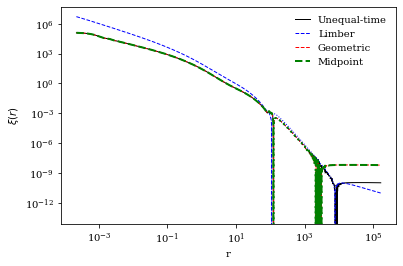

In [22]:
plt.figure(figsize=(6,4))
plt.loglog(r_uet, +xi_uet[0,0], 'k', label='Unequal-time', lw=1)
plt.loglog(r_uet, -xi_uet[0,0], '--k', lw=1)
plt.loglog(r_limb, +xi_limb[0], '--b', label='Limber', lw=1)
plt.loglog(r_limb, -xi_limb[0], ':b', lw=1)
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='Geometric', lw=1)
plt.loglog(r_geom, -xi_geom[0,0], ':r', lw=1)
plt.loglog(r_mid, +xi_mid[0,0], '--g', label='Midpoint', lw=2)
plt.loglog(r_mid, -xi_mid[0,0], ':g', lw=2)

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [23]:
from lens_filter import filter_galaxy_clustering, lensing_efficiency, filter_convergence

* Redshift distribution of galaxies

In [24]:
zn = np.loadtxt('../../data/des-y1-test/nz_source/z.txt')

In [25]:
xf = np.interp(zn, zdM, dM)

Source

In [26]:
nzslsst = np.zeros((len(zn),(len(zphs) + 1)))
for i in range(0,len(zn)):
    nzslsst[i] = nzis(zn[i], 0.13, 0.78)

Lens
       

In [27]:
nzlsst = np.zeros((len(zn),(len(zph) + 1)))
for i in range(0,len(zn)):
    nzlsst[i] = nzi(zn[i], 0.26, 0.94)

* Lensing efficiency

In [30]:
qlsst = [lensing_efficiency(xf, zn, nzslsst[:,i]) for i in range(nbinlsst)]

* Convergence

In [32]:
fclsst = [filter_convergence(xf, zn, qq, cosmo_astropy) for qq in qlsst]

* Galaxy clustering

In [34]:
g0 = growth_function(0, cosmo_astropy)
Dz = growth_function(zph, cosmo_astropy) / g0

In [35]:
bias_lsst = 0.95 / Dz   

In [37]:
fglsst = [filter_galaxy_clustering(xf, zn, nzlsst[:,i], bias_lsst[i], cosmo_astropy) for i in range(10)]

## 4. Angular correlation function

In [38]:
theta = np.logspace(-3, np.log10(np.pi), 64) 
theta_arcmin = np.degrees(theta)*60  

In [39]:
w_limb = [corfu.eqt(theta, (xf, fclsst[a-1]*fglsst[b-1]), (xp, r_limb, xi_limb)) for a, b in zip(binlsst_a, binlsst_b)]

In [40]:
w_geom = [corfu.uneqt(theta, (xf, fclsst[a-1]), (xf, fglsst[b-1]), (xp, xp, r_geom, xi_geom), True) for a, b in zip(binlsst_a, binlsst_b)]

100%|██████████| 276/276 [00:08<00:00, 32.70it/s]


In [41]:
w_uet = [corfu.uneqt(theta, (xf, fclsst[a-1]), (xf, fglsst[b-1]), (xp, xp, r_uet, xi_uet), True) for a, b in zip(binlsst_a, binlsst_b)]

100%|██████████| 276/276 [00:08<00:00, 32.43it/s]


In [42]:
w_mid = [corfu.uneqt(theta, (xf, fclsst[a-1]), (xf, fglsst[b-1]), (xp, xp, r_mid, xi_mid), True) for a, b in zip(binlsst_a, binlsst_b)]

100%|██████████| 276/276 [00:10<00:00, 26.24it/s]


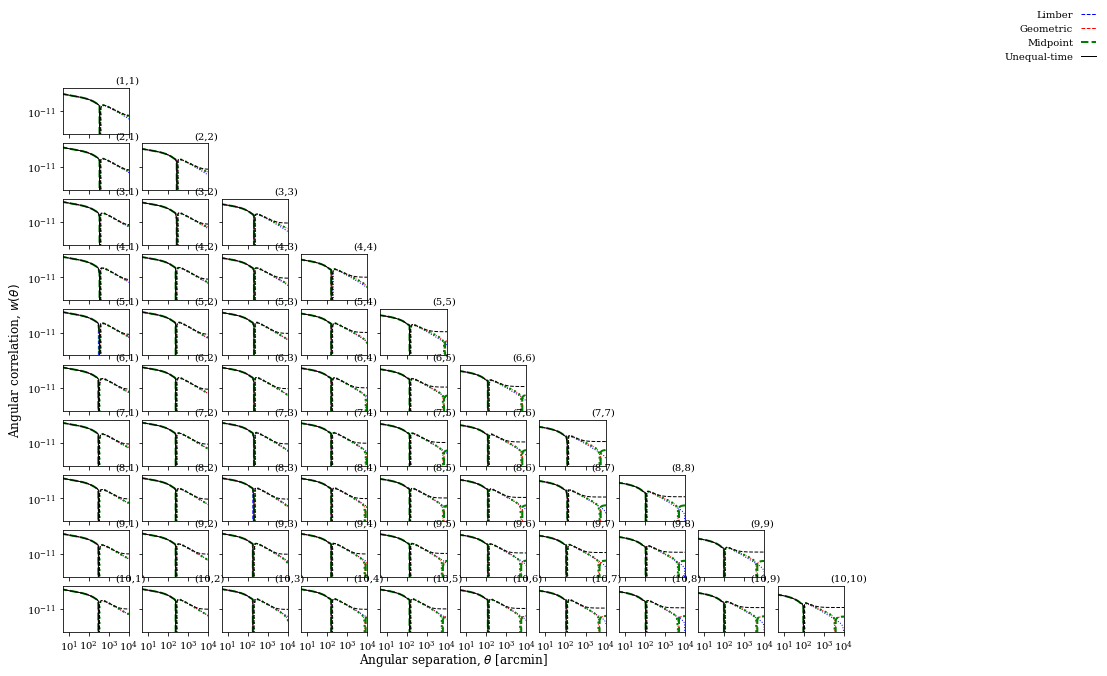

In [58]:
fig, axes = plt.subplots(10, 10, figsize=(14, 10), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(binlsst_a, binlsst_b)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(theta_arcmin, +w_limb[i], '--b', label='Limber', lw=1)
    ax.loglog(theta_arcmin, -w_limb[i], ':b', lw=1)
    ax.loglog(theta_arcmin, +w_geom[i], '--r', label='Geometric', lw=1)
    ax.loglog(theta_arcmin, -w_geom[i], ':r', lw=1)
    ax.loglog(theta_arcmin, +w_mid[i], '--g', label='Midpoint', lw=2)
    ax.loglog(theta_arcmin, -w_mid[i], ':g', lw=2)
    ax.loglog(theta_arcmin, +w_uet[i], 'k', label='Unequal-time', lw=1)
    ax.loglog(theta_arcmin, -w_uet[i], '--k', lw=1)
    
    ax.set_xlim(5e0, 1e4)
#     ax.set_ylim(5e-11, 2e-2)
    ax.set_xticks([1e1, 1e2, 1e3, 1e4])
    ax.tick_params(axis='y', which='minor', labelcolor='none')
    string = '({0},{1})'.format(a,b)
    ax.text(2e3,1e-4,string)

axes[0, 0].legend(markerfirst=False, bbox_to_anchor=(1.05, 1.0), bbox_transform=plt.gcf().transFigure, loc='upper left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular separation, $\theta$ [arcmin]', size=12)
ax.set_ylabel(r'Angular correlation, $w(\theta)$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=15)

# fig.tight_layout(pad=0.5)

# fig.savefig('plots/w_galaxy_lensing.pdf', bbox_inches='tight')

plt.show()

## 5. Angular power spectrum analysis

### 5.1. Angular power spectra

In [44]:
l_limb, cl_limb = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_limb], (1, 0, 2))

In [45]:
l_geom, cl_geom = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_geom], (1, 0, 2))

In [46]:
l_uet, cl_uet = np.transpose([corfu.wtocl(theta, w, lmax=2000) for w in w_uet], (1, 0, 2))

In [47]:
l_mid, cl_mid = np.transpose([corfu.wtocl(theta, w, lmax=2000)for w in w_mid], (1, 0, 2))

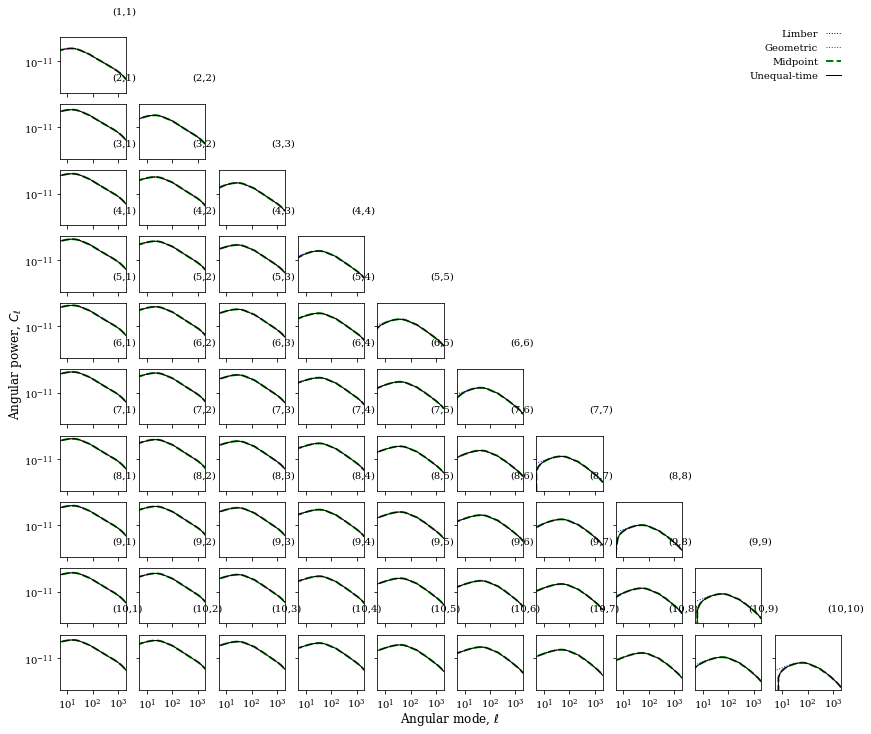

In [59]:
fig, axes = plt.subplots(10, 10, figsize=(14, 12), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(binlsst_a, binlsst_b)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.loglog(l_limb[i], cl_limb[i], ':b', label='Limber', lw=1)
    ax.loglog(l_geom[i], cl_geom[i], ':r', label='Geometric', lw=1) 
    ax.loglog(l_mid[i], cl_mid[i], '--g', label='Midpoint', lw=2)
    ax.loglog(l_uet[i], cl_uet[i], 'k', label='Unequal-time', lw=1)
    
    ax.set_xlim(5, 2e3)
#     ax.set_ylim(2e-10, 5e-7)
    ax.set_xticks([1e1, 1e2, 1e3])
    string = '({0},{1})'.format(a,b)
    ax.text(6e2,1e-7,string)

axes[0, 0].legend(markerfirst=False, bbox_to_anchor=(0.8, 0.9), bbox_transform=plt.gcf().transFigure, loc='upper left')


ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'Angular power, $C_{\ell}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

# fig.tight_layout(pad=0.5)

# fig.savefig('plots/cl_galaxy_lensing.pdf', bbox_inches='tight')

plt.show()

### 5.2. Relative error

In [51]:
frac_limb = cl_limb/cl_uet 
frac_geom = cl_geom/cl_uet
frac_mid = cl_mid/cl_uet
frac_uet = cl_uet/cl_uet

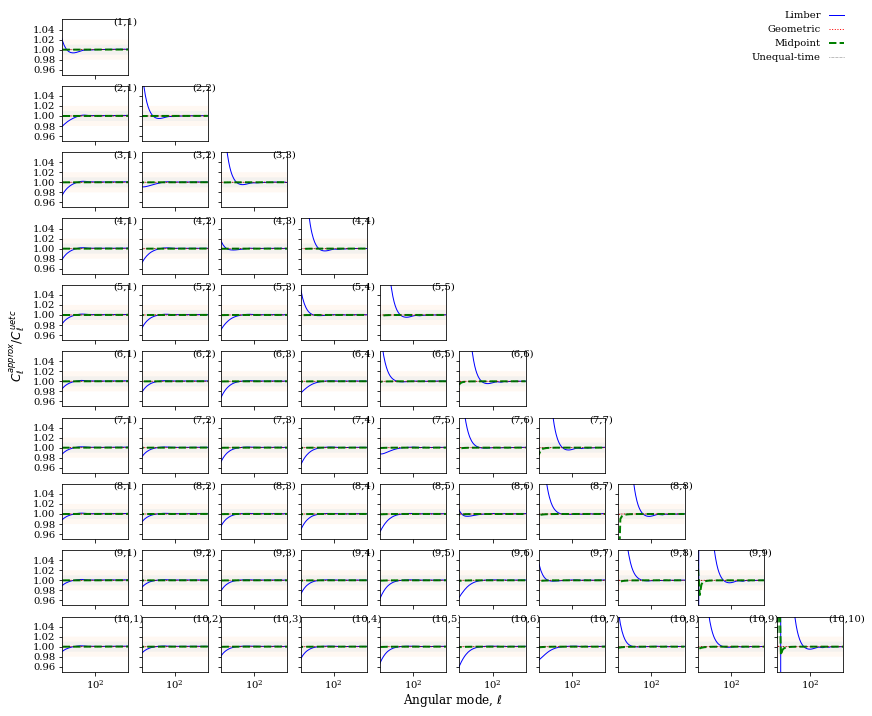

In [60]:
fig, axes = plt.subplots(10, 10, figsize=(14,12), sharex=True, sharey=True)

for ax in axes.ravel():
    ax.axis('off')

for i, (a, b) in enumerate(zip(binlsst_a, binlsst_b)):
    ax = axes[a-1, b-1]
    ax.axis('on')
    ax.semilogx(l_limb[i], frac_limb[i], 'b', label='Limber', lw=1)
    ax.semilogx(l_geom[i], frac_geom[i], ':r', label='Geometric', lw=1) 
    ax.semilogx(l_mid[i], frac_mid[i], '--g', label='Midpoint', lw=2)
    ax.semilogx(l_uet[i], frac_uet[i], ':k', label='Unequal-time', lw=0.5)
    
    ax.set_xlim(5, 2e3)
    ax.set_ylim(0.95, 1.06)
    ax.set_yticks([0.96, 0.98, 1, 1.02, 1.04])
    string = '({0},{1})'.format(a,b)
    ax.text(5e2,1.05,string)
    ax.fill_between(l_limb[i], 0.99, 1.01, alpha=0.05)
    ax.fill_between(l_limb[i], 0.98, 1.02, alpha=0.05)


axes[0, 0].legend(markerfirst=False, bbox_to_anchor=(0.8, 0.9), bbox_transform=plt.gcf().transFigure, loc='upper left')


ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'$C_{\ell}^{approx} / C_{\ell}^{uetc}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)

# fig.tight_layout(pad=0.5)

fig.savefig('plots/fraction_cl_galaxy_lensing.pdf', bbox_inches='tight')

plt.show()

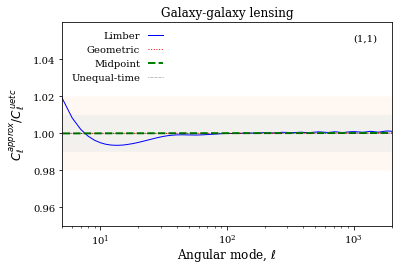

In [63]:
fig, axes = plt.subplots(1,1, figsize=(6,4), sharex=True, sharey=True)

ax = axes
ax.axis('on')
ax.semilogx(l_limb[0], frac_limb[0], 'b', label='Limber', lw=1)
ax.semilogx(l_geom[0], frac_geom[0], ':r', label='Geometric', lw=1) 
ax.semilogx(l_mid[0], frac_mid[0], '--g', label='Midpoint', lw=2)
ax.semilogx(l_uet[0], frac_uet[0], ':k', label='Unequal-time', lw=0.5)
    
ax.set_xlim(5, 2e3)
ax.set_ylim(0.95, 1.06)
ax.set_yticks([0.96, 0.98, 1, 1.02, 1.04])
string = '({0},{1})'.format(1,1)
ax.text(1e3,1.05,string)
ax.fill_between(l_limb[0], 0.99, 1.01, alpha=0.05)
ax.fill_between(l_limb[0], 0.98, 1.02, alpha=0.05)


axes.legend(markerfirst=False, loc='upper left')

ax = fig.add_subplot(111, frameon=False)
ax.set_xlabel(r'Angular mode, $\ell$', size=12)
ax.set_ylabel(r'$C_{\ell}^{approx} / C_{\ell}^{uetc}$', size=12)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.tick_params(axis='y', pad=12)
ax.set_title('Galaxy-galaxy lensing')

fig.tight_layout(pad=0.5)

# fig.savefig('plots/bin11_cl_galaxy_lensing.pdf', bbox_inches='tight')

plt.show()